标题：人脸颜值打分模型

作者：Koorye

日期：2020-11-14

使用第三方库：
- Tensorflow2.Keras 搭建神经网络模型
- Pandas 处理数据
- Numpy 科学运算
- PIL 图像的简单处理
- OS 系统操作 (文件的增删改查)
- Shutil 同上
- Sklearn 机器学习包

In [27]:
import tensorflow as tf
import pandas as pd
import numpy as np
import PIL.Image
import os
import shutil
import sklearn.model_selection
import matplotlib.pyplot as plt

预处理图像：
1. 输入一张图片的路径
2. 拉伸成对应尺寸
3. 转换成 RGB 三通道的 Numpy 数组 (宽, 高, RGB)

In [28]:
def convert_image_to_array(img_path, img_width, img_height):
    """ 对图像进行预处理，转换成对应宽高的三通道颜色三维数组 """
    img = PIL.Image.open(img_path)
    img = img.resize((img_width, img_height))
    return np.array(img.convert('RGB')).reshape((img_width, img_height, 3)).astype('float32')

In [29]:
def convert_dir_to_arrays(dir_path, img_width, img_height):
    """ 对图像目录进行批量预处理转换 """
    files = os.listdir(dir_path)
    arrays = []
    for file in files:
        if file.endswith('.jpg'):
            arrays.append(convert_image_to_array(dir_path+'/' + file, img_width, img_height))
    return np.array(arrays)

以追加模式保存数据为 CSV，不设置表头和目录。

用于损失函数数据的保存。

In [30]:
def save_data_as_csv(data, path, header):
    """ 将 DataFrame 保存为 CSV """
    if os.path.exists(path):
        data.to_csv(path, mode='a', header=None, index=None)
    else:
        data.to_csv(path, mode='a', header=header, index=None)

模型主体：
- 初始化流程：
  1. 设定图片宽高 (影响特征的维度)
  2. 读取图片目录并转化为样本集 (样本数, 宽, 高, RGB)
  3. 读取标签
  4. 切割样本集为训练集和测试集
  5. 构建神经网络模型 ResNet50 + Dropout + Dense(Sigmoid)
  6. 实现模型的保存和读取

- 训练流程：
  1. 如果不训练新模型 (默认)，就读取旧模型
  2. 使用 SGD 作为学习器，均方差作为损失函数
  3. 训练并保存模型和损失

- 预测流程：
  1. 喂入图片，转换成(样本数, 宽, 高, RGB) 的四维矩阵 (其中样本数=1)
  2. 使用模型的预测函数进行预测
  3. 将预测结果提取出来

In [31]:
class Model:
    """ 人脸颜值打分模型，使用 ResNet50 作为基模型 """
    def __init__(self):
        """ 初始化矩阵尺寸，数据集预处理，划分训练集与测试集，搭建网络模型，实现断点续训 """
        self.img_width, self.img_height = 100, 120

        self.data = convert_dir_to_arrays('data/female-face/allpicture', self.img_width, self.img_height)

        self.target = np.array(pd.read_excel('data/female-face/grades.xlsx')['label']) / 5

        self.x_train, self.x_test, self.y_train, self.y_test = sklearn.model_selection.train_test_split(self.data,
                                                                                                        self.target,
                                                                                                        test_size=0.3,
                                                                                                        random_state=0)

        self.model = tf.keras.Sequential([
                tf.keras.applications.ResNet50(include_top=False, pooling='avg'),
                tf.keras.layers.Dropout(0.5),
                tf.keras.layers.Dense(1, activation='sigmoid')])

        self.base_path = 'face_marking_model'
        self.checkpoint_save_path = 'checkpoint/mnist.ckpt'

        self.cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=self.base_path + '/' + self.checkpoint_save_path,
                                                              save_weights_only=True,
                                                              save_best_only=True)

        self.model.load_weights(self.base_path + '/' + self.checkpoint_save_path)


    def fit(self, epochs, new_model=False):
        """ 训练模型，设定训练次数和是否使用新模型 (使用新模型将删除训练好的模型！) """
        if new_model:
            print('[ WARN ] >>> All record of model will be removed!')
            if os.path.exists(self.base_path):
                shutil.rmtree(self.base_path)

        else:
            if os.path.exists(self.base_path + '/' + self.checkpoint_save_path + '.index'):
                print('[ INFO ] >>> Model is exist! Loading the model!')
                self.model.load_weights(self.base_path + '/' + self.checkpoint_save_path)
            else:
                print('[ INFO ] >>> Model is not exist! Creating the model!')

        self.model.compile(optimizer='sgd',
                           loss='mse')

        self.model.fit(self.x_train,
                       self.y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(self.x_test, self.y_test),
                       validation_freq=1,
                       callbacks=[self.cp_callback])

        save_data_as_csv(pd.concat([pd.DataFrame(self.model.history.history['loss']),
                                    pd.DataFrame(self.model.history.history['val_loss'])],
                                    axis=1),
                 path=self.base_path + '/' + 'loss.csv',
                 header=['loss', 'val_loss'])

    def predict(self, img_path):
        """ 预测分数，输入一张图片的路径 """
        return self.model.predict(convert_image_to_array(img_path, self.img_width, self.img_height).reshape(1, self.img_width, self.img_height, 3)).flatten()[0]

In [32]:
model = Model()

C:\environment\Python3.8.5\lib\site-packages\PIL\TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


In [16]:
model.fit(10, new_model=False)

[ INFO ] >>> Model is exist! Loading the model!
Epoch 1/10
6/6 [==============================] - 69s 11s/step - loss: 0.0139 - val_loss: 0.0147
Epoch 2/10
6/6 [==============================] - 69s 11s/step - loss: 0.0135 - val_loss: 0.0153
Epoch 3/10
6/6 [==============================] - 83s 14s/step - l

<AxesSubplot:>

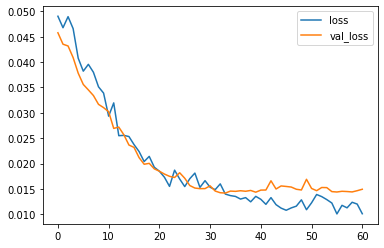

In [35]:
pd.read_csv(model.base_path + '/loss.csv').plot()

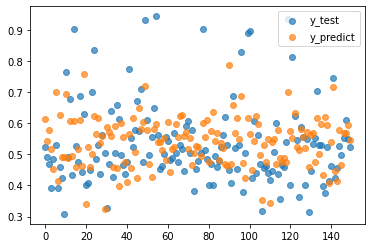

In [24]:
y_test, y_predict = model.y_test, model.model.predict(model.x_test)

# zipped = sorted(zip(y_test, y_predict))
# y_test, y_predict = [], []
# for each in zipped:
#     y_test.append(each[0])
#     y_predict.append(each[1])

plt.scatter(range(len(y_test)), y_test, label='y_test', alpha=0.7)
plt.scatter(range(len(y_test)), y_predict, label='y_predict', alpha=0.7)
plt.legend()

In [33]:
model.predict('a2f607824ce2ae7feeac3ec5d1542280.jpg') * 5

3.259947896003723

In [34]:
model.predict('900ba11a29acd697088fab14eddfb8db.jpg') * 5

3.39241623878479